In [2]:
import sys
import numpy as np
import pandas as pd
from bayes_ensemble import *
sys.path.append('../')
from utils import *

In [3]:
df_preds_all, models_by_state, data_all = load_preds(rename = False)

df_preds_all = df_preds_all.loc[df_preds_all.model_id.isin(['21', '22', '25', '26', '27', '28', '30', '34'] )]

df_preds_all['model_id'] = df_preds_all['model_id'].astype(int)

df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,21
2800,2025-08-10,192.641953,142.814506,261.828157,PR,21
2801,2025-08-17,171.137457,119.943438,233.918928,PR,21
2802,2025-08-24,196.875395,132.696765,267.461459,PR,21
2803,2025-08-31,179.610112,136.303073,247.230651,PR,21


In [14]:
def gen_ensemble_linear(preds_23, preds_24, preds_25, models, fn_loss = 'median'):

    ens_23 = Ensemble_linear(df= preds_23,
            order_models = models, fn_loss = fn_loss)

    K = len(models)
    weights = np.full(K, 1/(K))

    df_23_in = ens_23.apply_ensemble(weights = weights)

    ens_24 = Ensemble_linear(df= preds_24,
            order_models = models, fn_loss = fn_loss)

    df_24_out = ens_24.apply_ensemble(weights = weights)

    df_23_24_ = pd.concat([df_23_in, df_24_out], ignore_index = True)

    df_23_24_['state'] = state
 
    #### Forecast 2025

    ens_25 = Ensemble_linear(df= preds_25,
            order_models = models, fn_loss = fn_loss)

    df_25_ = ens_25.apply_ensemble(weights = weights)

    df_25_['state'] = state

    return pd.concat([df_23_24_, df_25_], ignore_index = True)

In [20]:
def gen_ensemble(data_23, data_24, preds_23, preds_24, preds_25, models, fn_loss = 'median'):

    ens_23 = Ensemble(df= preds_23,
            order_models = models, dist='log_normal', fn_loss = fn_loss)

    weights_23 = ens_23.compute_weights(df_obs = data_23, metric = 'crps')['weights']

    df_23_in = ens_23.apply_ensemble(weights = weights_23)

    ens_24 = Ensemble(df= preds_24,
            order_models = models,  dist='log_normal', fn_loss = fn_loss)

    weights_24 = ens_24.compute_weights(data_24, metric = 'crps')['weights']
    
    df_24_out = ens_24.apply_ensemble(weights = weights_23)

    df_23_24_ = pd.concat([df_23_in, df_24_out], ignore_index = True)

    df_23_24_['state'] = state
 
    #### Forecast 2025

    ens_25 = Ensemble(df= preds_25,
            order_models = models,  dist='log_normal', fn_loss = fn_loss)

    df_25_ = ens_25.apply_ensemble(weights = weights_24)

    df_25_['state'] = state

    return pd.concat([df_23_24_, df_25_], ignore_index = True)

In [15]:
dist = 'log_normal'
state = 'MG'
    
data_23, data_24, preds_23, preds_24, preds_25, models = format_data(state, models_by_state, data_all, df_preds_all)
    
df_e1_lower = gen_ensemble_linear(preds_23, preds_24, preds_25, models, fn_loss = 'lower')

df_e1_lower = df_e1_lower.sort_values(by='date')
df_e1_median = gen_ensemble_linear(preds_23, preds_24, preds_25, models, fn_loss = 'median')
df_e1_median = df_e1_median.sort_values(by='date')


/Users/eduardoaraujo/Documents/Github/Dengue-Forecast-Ensemble/bayes_ensemble/../utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds.date = pd.to_datetime(preds.date)


In [21]:
df_e2_lower = gen_ensemble(data_23, data_24, preds_23, preds_24, preds_25, models, fn_loss = 'lower')

df_e2_lower = df_e2_lower.sort_values(by='date')
df_e2_median =  gen_ensemble(data_23, data_24, preds_23, preds_24, preds_25, models, fn_loss = 'median')
df_e2_median = df_e2_median.sort_values(by='date')


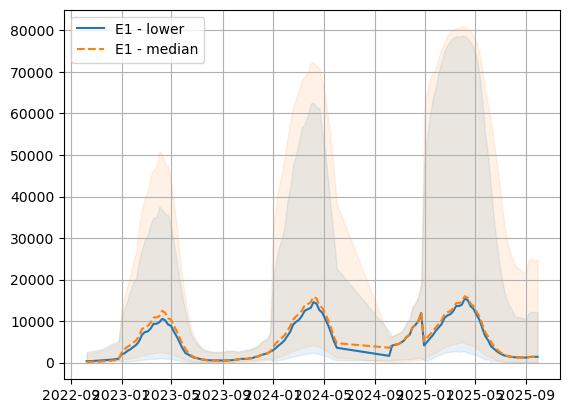

In [17]:
_,ax = plt.subplots()

ax.plot(df_e1_lower.date, df_e1_lower.pred, label = 'E1 - lower', color = 'tab:blue')
    
ax.fill_between(df_e1_lower.date, df_e1_lower.lower, df_e1_lower.upper, alpha=0.1, color = 'tab:blue')
    
ax.plot(df_e1_median.date, df_e1_median.pred, label = 'E1 - median', color = 'tab:orange', linestyle = '--')

ax.fill_between(df_e1_median.date, df_e1_median.lower, df_e1_median.upper, alpha=0.1, color = 'tab:orange')

ax.grid()
ax.legend()

plt.show()

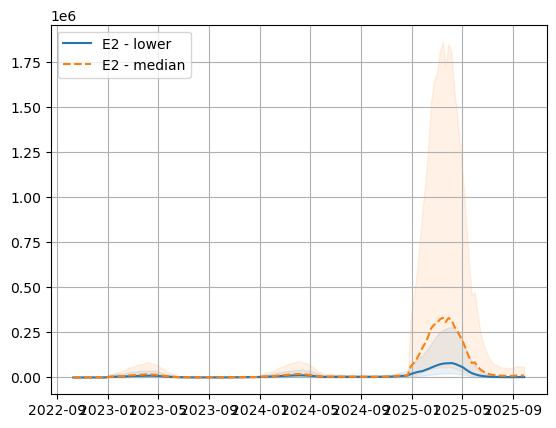

In [22]:
_,ax = plt.subplots()

ax.plot(df_e2_lower.date, df_e2_lower.pred, label = 'E2 - lower', color = 'tab:blue')
    
ax.fill_between(df_e2_lower.date, df_e2_lower.lower, df_e2_lower.upper, alpha=0.1, color = 'tab:blue')
    
ax.plot(df_e2_median.date, df_e2_median.pred, label = 'E2 - median', color = 'tab:orange', linestyle = '--')

ax.fill_between(df_e2_median.date, df_e2_median.lower, df_e2_median.upper, alpha=0.1, color = 'tab:orange')

ax.grid()
ax.legend()

plt.show()

In [27]:
preds_25.loc[preds_25.upper == preds_25.upper.max()]

,date,pred,lower,upper,state,model_id
105,2025-03-16,400521.016961,5109.042551,2.375592e+06,MG,28


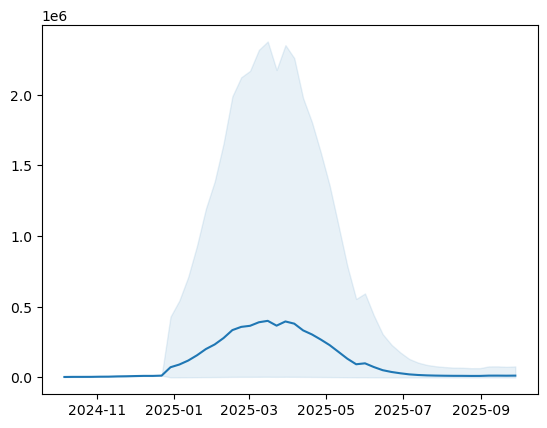

In [31]:
preds_ = preds_25.loc[preds_25.model_id == 28]

preds_ = preds_.sort_values(by = 'date')
_,ax = plt.subplots()

ax.plot(preds_.date, preds_.pred, color = 'tab:blue')
    
ax.fill_between(preds_.date, preds_.lower, preds_.upper, alpha=0.1, color = 'tab:blue')
    